# Fine-tuning modelu tłumaczenia EN→PL z wykorzystaniem LoRA

## Testy i eksperymenty z LoRA na różnych modelach
W poniższej sekcji przeprowadzimy kilka eksperymentów z różnymi modelami i konfiguracjami LoRA.

In [1]:
import os
import numpy as np
import sacrebleu
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq,
    pipeline,
)
import matplotlib.pyplot as plt
from peft import LoraConfig, get_peft_model, PeftModel
import torch

RESULTS_DIR = "results_en_pl"
os.makedirs(RESULTS_DIR, exist_ok=True)

/Users/amika/python-global/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def prepare_datasets(train_size: int, val_size: int = 5000, max_len: int = 128):
    """
    Ładuje korpus OPUS100 en-pl,
    wybiera losowy subset train_size i subset walidacyjny do actual_val_size,
    tokenizuje do max_len.
    """
    raw = load_dataset("opus100", "en-pl")

    available_val = len(raw["validation"])
    actual_val_size = min(val_size, available_val)

    train_raw = raw["train"].shuffle(seed=42).select(range(train_size))
    val_raw = raw["validation"].shuffle(seed=42).select(range(actual_val_size))

    def preprocess(batch):
        en_list = [example["en"] for example in batch["translation"]]
        pl_list = [example["pl"] for example in batch["translation"]]

        in_tok = tokenizer(
            en_list,
            truncation=True,
            padding="max_length",
            max_length=max_len
        )
        out_tok = tokenizer(
            pl_list,
            truncation=True,
            padding="max_length",
            max_length=max_len
        )
        return {
            "input_ids": in_tok["input_ids"],
            "attention_mask": in_tok["attention_mask"],
            "labels": out_tok["input_ids"],
        }

    train_ds = train_raw.map(preprocess, batched=True, remove_columns=train_raw.column_names)
    val_ds = val_raw.map(preprocess, batched=True, remove_columns=val_raw.column_names)
    return train_ds, val_ds


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    bleu = sacrebleu.corpus_bleu(decoded_preds, [decoded_labels])
    return {"bleu": bleu.score}


def save_lora_adapter(model, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    model.save_pretrained(output_dir)

In [3]:
device = 0 if torch.cuda.is_available() else -1
print("Urządzenie:", "cuda" if device == 0 else "cpu")

Urządzenie: cpu


### Eksperyment z gsarti (20k próbek, 3 epoki, LoRA r=8, max_len=128)
Niestety nie ma oficjalnego modelu Helsinki NLP dla tłumaczenia EN→PL, więc użyjemy modelu `gsarti/opus-mt-tc-en-pl`, który jest oparty na OpenNMT i przeszkolony na korpusie OPUS100.

In [4]:
config_1 = {
    "base_model_id": "gsarti/opus-mt-tc-en-pl",
    "train_size": 20000,
    "val_size": 2000,
    "num_epochs": 3,
    "lora_r": 8,
    "batch_size": 16,
    "learning_rate": 5e-5,
    "max_len": 128,
    "num_beams": 1,
}

In [5]:
exp_name_1 = (
    f"gsarti_enpl_"
    f"train{config_1['train_size'] // 1000}k_"
    f"ep{config_1['num_epochs']}_"
    f"r{config_1['lora_r']}_"
    f"len{config_1['max_len']}"
)

#### Tokenizer i LoRA model

In [6]:
tokenizer = AutoTokenizer.from_pretrained(config_1["base_model_id"])
base_model = AutoModelForSeq2SeqLM.from_pretrained(config_1["base_model_id"])

lora_config = LoraConfig(
    r=config_1["lora_r"],
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_2_SEQ_LM",
)
model = get_peft_model(base_model, lora_config)

#### Przygotowanie danych

In [7]:
train_ds, val_ds = prepare_datasets(
    train_size=config_1["train_size"],
    val_size=config_1["val_size"],
    max_len=config_1["max_len"],
)

In [8]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, label_pad_token_id=-100)

In [9]:
output_dir_1 = os.path.join(RESULTS_DIR, exp_name_1)
os.makedirs(output_dir_1, exist_ok=True)

training_args_1 = Seq2SeqTrainingArguments(
    output_dir=output_dir_1,
    per_device_train_batch_size=config_1["batch_size"],
    per_device_eval_batch_size=config_1["batch_size"],
    predict_with_generate=True,
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    logging_steps=100,
    num_train_epochs=config_1["num_epochs"],
    learning_rate=config_1["learning_rate"],
    warmup_steps=500,
    weight_decay=0.01,
    label_smoothing_factor=0.1,
    generation_max_length=config_1["max_len"],
    generation_num_beams=config_1["num_beams"],
    load_best_model_at_end=True,
    metric_for_best_model="bleu",
    greater_is_better=True,
)

#### Seq2SeqTrainer i trening

In [10]:
trainer_1 = Seq2SeqTrainer(
    model=model,
    args=training_args_1,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer_1.train()

/var/folders/z_/dq8r0xg94mxfzfpr1jmhv_740000gn/T/ipykernel_14366/3083131843.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer_1 = Seq2SeqTrainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss,Validation Loss,Bleu
500,2.076000,2.103680,24.563303
1000,1.980100,2.008930,16.215382
1500,1.953900,1.987981,15.686271
2000,1.948800,1.976382,14.882877
2500,1.936400,1.969475,13.996033
3000,1.952900,1.966237,14.607560
3500,1.935100,1.963901,14.325279


/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/si

TrainOutput(global_step=3750, training_loss=2.1416270060221354, metrics={'train_runtime': 2607.3168, 'train_samples_per_second': 23.012, 'train_steps_per_second': 1.438, 'total_flos': 2047491440640000.0, 'train_loss': 2.1416270060221354, 'epoch': 3.0})

In [11]:
best_bleu_1 = trainer_1.state.best_metric
print(f"{exp_name_1} → BEST BLEU: {best_bleu_1:.2f}")

gsarti_enpl_train20k_ep3_r8_len128 → BEST BLEU: 24.56


In [12]:
adapter_dir_1 = os.path.join(output_dir_1, "lora_adapter")
save_lora_adapter(model, adapter_dir_1)

#### Testowanie modelu

In [13]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from peft import PeftModel
import torch
import os

LORA_DIR = "results_en_pl/gsarti_enpl_train20k_ep3_r8_len128/lora_adapter"

MODEL_NAME = "gsarti/opus-mt-tc-en-pl"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
base_model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

model = PeftModel.from_pretrained(
    base_model,
    LORA_DIR,
    local_files_only=True
)

device = 0 if torch.cuda.is_available() else -1
translator_enpl = pipeline(
    "translation",
    model=model,
    tokenizer=tokenizer,
    device=device
)

test_sentences = [
    "Hello, how are you?",
    "This is a test of the English to Polish translator.",
    "I love programming in Python!",
]

for s in test_sentences:
    out = translator_enpl(s)
    print(f">>> EN : {s}")
    print(f"    PL : {out[0]['translation_text']}\n")

Device set to use cpu


>>> EN : Hello, how are you?
    PL : Cześć, jak się masz?

>>> EN : This is a test of the English to Polish translator.
    PL : To jest test angielsko-polskiego tłumacza.

>>> EN : I love programming in Python!
    PL : Uwielbiam programowanie w Pythonie!



### Eksperyment z gsarti (20k próbek, 7 epok, LoRA r=8, max_len=128)

In [14]:
config_2 = config_1.copy()
config_2["num_epochs"] = 7

In [15]:
exp_name_2 = (
    f"gsarti_enpl_"
    f"train{config_2['train_size'] // 1000}k_"
    f"ep{config_2['num_epochs']}_"
    f"r{config_2['lora_r']}_"
    f"len{config_2['max_len']}"
)

In [16]:
tokenizer = AutoTokenizer.from_pretrained(config_2["base_model_id"])
base_model = AutoModelForSeq2SeqLM.from_pretrained(config_2["base_model_id"])

lora_config = LoraConfig(
    r=config_2["lora_r"],
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_2_SEQ_LM",
)
model = get_peft_model(base_model, lora_config)

In [17]:
train_ds, val_ds = prepare_datasets(
    train_size=config_2["train_size"],
    val_size=config_2["val_size"],
    max_len=config_2["max_len"],
)

In [18]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, label_pad_token_id=-100)

In [19]:
output_dir_2 = os.path.join(RESULTS_DIR, exp_name_2)
os.makedirs(output_dir_2, exist_ok=True)

training_args_2 = Seq2SeqTrainingArguments(
    output_dir=output_dir_2,
    per_device_train_batch_size=config_2["batch_size"],
    per_device_eval_batch_size=config_2["batch_size"],
    predict_with_generate=True,
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    logging_steps=100,
    num_train_epochs=config_2["num_epochs"],
    learning_rate=config_2["learning_rate"],
    warmup_steps=500,
    weight_decay=0.01,
    label_smoothing_factor=0.1,
    generation_max_length=config_2["max_len"],
    generation_num_beams=config_2["num_beams"],
    load_best_model_at_end=True,
    metric_for_best_model="bleu",
    greater_is_better=True,
)

In [20]:
trainer_2 = Seq2SeqTrainer(
    model=model,
    args=training_args_2,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer_2.train()

/var/folders/z_/dq8r0xg94mxfzfpr1jmhv_740000gn/T/ipykernel_14366/2927731541.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer_2 = Seq2SeqTrainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Bleu
500,2.073900,2.102502,24.471471
1000,1.974600,2.003755,15.678642
1500,1.948500,1.982327,15.206754
2000,1.941900,1.968858,14.586026
2500,1.927900,1.959386,13.709861
3000,1.940900,1.953213,14.550695
3500,1.920100,1.946122,13.759360
4000,1.921500,1.940862,13.574526
4500,1.905900,1.936573,13.214324
5000,1.900300,1.933126,13.421774


/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/si

TrainOutput(global_step=8750, training_loss=1.996553693498884, metrics={'train_runtime': 6381.7625, 'train_samples_per_second': 21.938, 'train_steps_per_second': 1.371, 'total_flos': 4777480028160000.0, 'train_loss': 1.996553693498884, 'epoch': 7.0})

In [21]:
best_bleu_2 = trainer_2.state.best_metric
print(f"{exp_name_2} → BEST BLEU: {best_bleu_2:.2f}")

gsarti_enpl_train20k_ep7_r8_len128 → BEST BLEU: 24.47


In [22]:
adapter_dir_2 = os.path.join(output_dir_2, "lora_adapter")
save_lora_adapter(model, adapter_dir_2)

### Eksperyment z gsarti (100k próbek, 7 epok, LoRA r=8, max_len=128)

In [23]:
config_3 = config_1.copy()
config_3["train_size"] = 100000
config_3["num_epochs"] = 7

In [24]:
exp_name_3 = (
    f"gsarti_enpl_"
    f"train{config_3['train_size'] // 1000}k_"
    f"ep{config_3['num_epochs']}_"
    f"r{config_3['lora_r']}_"
    f"len{config_3['max_len']}"
)

In [25]:
tokenizer = AutoTokenizer.from_pretrained(config_3["base_model_id"])
base_model = AutoModelForSeq2SeqLM.from_pretrained(config_3["base_model_id"])

lora_config = LoraConfig(
    r=config_3["lora_r"],
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_2_SEQ_LM",
)
model = get_peft_model(base_model, lora_config)

In [26]:
train_ds, val_ds = prepare_datasets(
    train_size=config_3["train_size"],
    val_size=config_3["val_size"],
    max_len=config_3["max_len"],
)

In [27]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, label_pad_token_id=-100)

In [28]:
output_dir_3 = os.path.join(RESULTS_DIR, exp_name_3)
os.makedirs(output_dir_3, exist_ok=True)

training_args_3 = Seq2SeqTrainingArguments(
    output_dir=output_dir_3,
    per_device_train_batch_size=config_3["batch_size"],
    per_device_eval_batch_size=config_3["batch_size"],
    predict_with_generate=True,
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    logging_steps=100,
    num_train_epochs=config_3["num_epochs"],
    learning_rate=config_3["learning_rate"],
    warmup_steps=500,
    weight_decay=0.01,
    label_smoothing_factor=0.1,
    generation_max_length=config_3["max_len"],
    generation_num_beams=config_3["num_beams"],
    load_best_model_at_end=True,
    metric_for_best_model="bleu",
    greater_is_better=True,
)

In [29]:
trainer_3 = Seq2SeqTrainer(
    model=model,
    args=training_args_3,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer_3.train()

/var/folders/z_/dq8r0xg94mxfzfpr1jmhv_740000gn/T/ipykernel_14366/3904490955.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer_3 = Seq2SeqTrainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Bleu
500,2.074400,2.103265,24.616333
1000,1.974800,2.004170,16.382360
1500,1.938300,1.982019,15.488256
2000,1.971200,1.968493,14.665093
2500,1.915300,1.957545,14.446485
3000,1.904800,1.949271,13.880592
3500,1.897200,1.940325,13.265628
4000,1.892300,1.933667,13.381764
4500,1.898900,1.927066,13.383475
5000,1.903800,1.922257,13.077818


/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/si

TrainOutput(global_step=43750, training_loss=1.8717772635323662, metrics={'train_runtime': 33265.9938, 'train_samples_per_second': 21.043, 'train_steps_per_second': 1.315, 'total_flos': 2.38874001408e+16, 'train_loss': 1.8717772635323662, 'epoch': 7.0})

In [30]:
best_bleu_3 = trainer_3.state.best_metric
print(f"{exp_name_3} → BEST BLEU: {best_bleu_3:.2f}")

gsarti_enpl_train100k_ep7_r8_len128 → BEST BLEU: 24.62


In [31]:
adapter_dir_3 = os.path.join(output_dir_3, "lora_adapter")
save_lora_adapter(model, adapter_dir_3)

### Podsumowanie wyników eksperymentów

In [32]:
import pandas as pd

results_table = [
    {"experiment": exp_name_1, "BLEU": best_bleu_1},
    {"experiment": exp_name_2, "BLEU": best_bleu_2},
    {"experiment": exp_name_3, "BLEU": best_bleu_3},
]
df_results = pd.DataFrame(results_table)
df_results

,experiment,BLEU
0,gsarti_enpl_train20k_ep3_r8_len128,24.563303
1,gsarti_enpl_train20k_ep7_r8_len128,24.471471
2,gsarti_enpl_train100k_ep7_r8_len128,24.616333


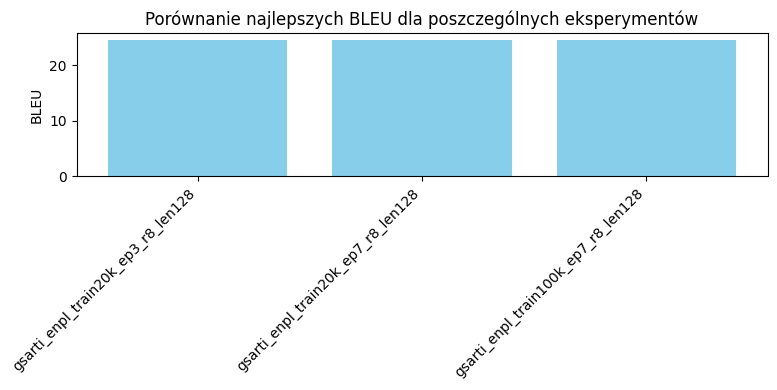

In [33]:
plt.figure(figsize=(8, 4))
plt.bar(df_results["experiment"], df_results["BLEU"], color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.ylabel("BLEU")
plt.title("Porównanie najlepszych BLEU dla poszczególnych eksperymentów")
plt.tight_layout()
plt.show()

In [34]:
def extract_loss_history(trainer):
    """
    Z obiektu Trainer wyciąga listę słowników 'log_history',
    filtruje wpisy, które mają klucze 'loss' (trening) i 'eval_loss' (validation).
    Zwraca dwa DataFrame'y: jeden z loss, drugi z eval_loss.
    """
    history = trainer.state.log_history  # lista słowników

    train_entries = [entry for entry in history if "loss" in entry and "epoch" in entry]

    eval_entries = [entry for entry in history if "eval_loss" in entry]

    df_train = pd.DataFrame(train_entries)[["step", "epoch", "loss"]].dropna().reset_index(drop=True)
    df_eval = pd.DataFrame(eval_entries)[["step", "epoch", "eval_loss"]].dropna().reset_index(drop=True)
    return df_train, df_eval


train_hist_1, eval_hist_1 = extract_loss_history(trainer_1)
train_hist_2, eval_hist_2 = extract_loss_history(trainer_2)
train_hist_3, eval_hist_3 = extract_loss_history(trainer_3)

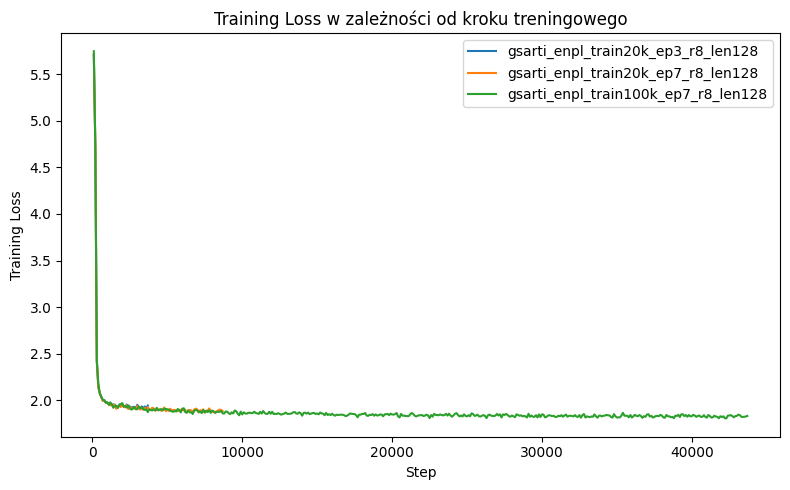

In [35]:
plt.figure(figsize=(8, 5))
plt.plot(train_hist_1["step"], train_hist_1["loss"], label=exp_name_1)
plt.plot(train_hist_2["step"], train_hist_2["loss"], label=exp_name_2)
plt.plot(train_hist_3["step"], train_hist_3["loss"], label=exp_name_3)
plt.xlabel("Step")
plt.ylabel("Training Loss")
plt.title("Training Loss w zależności od kroku treningowego")
plt.legend()
plt.tight_layout()
plt.show()

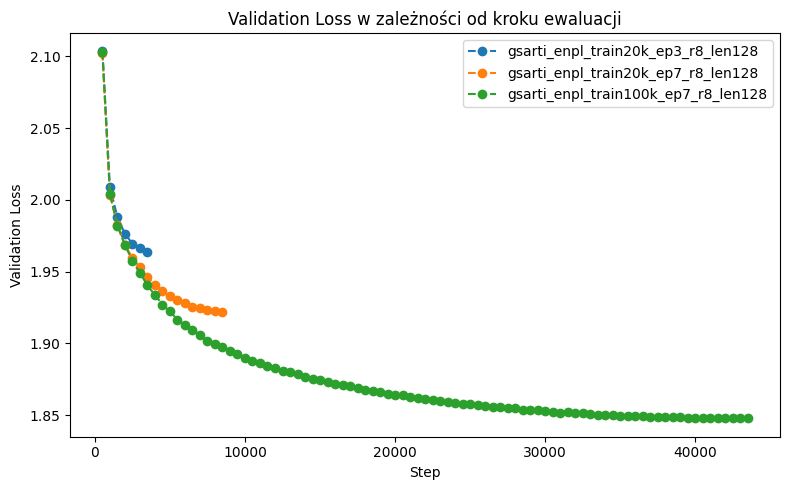

In [36]:
plt.figure(figsize=(8, 5))
plt.plot(eval_hist_1["step"], eval_hist_1["eval_loss"], marker="o", linestyle="--", label=exp_name_1)
plt.plot(eval_hist_2["step"], eval_hist_2["eval_loss"], marker="o", linestyle="--", label=exp_name_2)
plt.plot(eval_hist_3["step"], eval_hist_3["eval_loss"], marker="o", linestyle="--", label=exp_name_3)
plt.xlabel("Step")
plt.ylabel("Validation Loss")
plt.title("Validation Loss w zależności od kroku ewaluacji")
plt.legend()
plt.tight_layout()
plt.show()

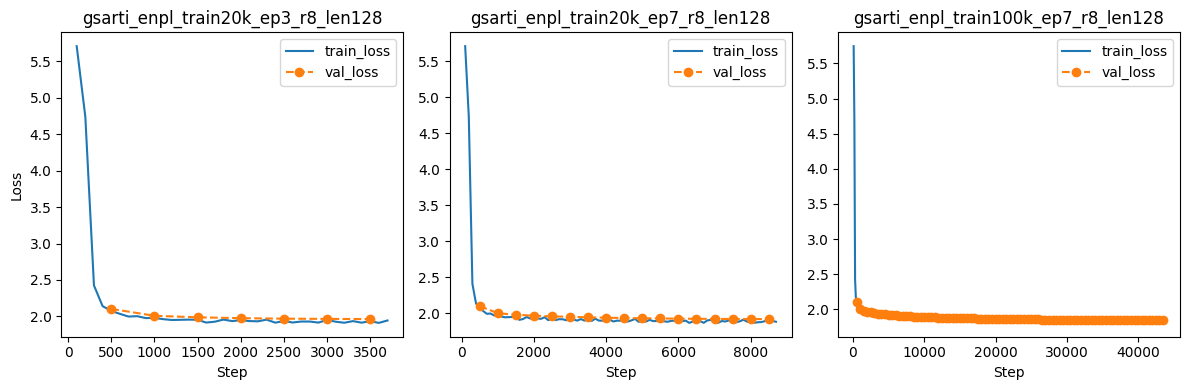

In [37]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(train_hist_1["step"], train_hist_1["loss"], label="train_loss", color="tab:blue")
plt.plot(eval_hist_1["step"], eval_hist_1["eval_loss"], label="val_loss", color="tab:orange", linestyle="--",
         marker="o")
plt.title(exp_name_1)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_hist_2["step"], train_hist_2["loss"], label="train_loss", color="tab:blue")
plt.plot(eval_hist_2["step"], eval_hist_2["eval_loss"], label="val_loss", color="tab:orange", linestyle="--",
         marker="o")
plt.title(exp_name_2)
plt.xlabel("Step")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_hist_3["step"], train_hist_3["loss"], label="train_loss", color="tab:blue")
plt.plot(eval_hist_3["step"], eval_hist_3["eval_loss"], label="val_loss", color="tab:orange", linestyle="--",
         marker="o")
plt.title(exp_name_3)
plt.xlabel("Step")
plt.legend()

plt.tight_layout()
plt.show()

### Podsumowanie eksperymentów LoRA: tłumaczenie EN→PL (gsarti/opus-mt-tc-en-pl)

Wykonaliśmy trzy główne eksperymenty z adapterem LoRA na modelu `gsarti/opus-mt-tc-en-pl`. Różniły się one przede wszystkim liczbą przykładów w zbiorze treningowym i liczbą epok. Wszystkie testy prowadzone były z:
- **r = 8** (rząd adaptacji LoRA),
- **max_length = 128** (maksymalna długość sekwencji),
- **learning_rate = 3e-5**, **weight_decay = 0.01**.

Poniżej lista trzech konfiguracji:
1. **`gsarti_enpl_train20k_ep3_r8_len128`**
   - Zbiór treningowy: 20 000 par zdaniowych EN–PL.
   - Liczba epok: 3.

2. **`gsarti_enpl_train20k_ep7_r8_len128`**
   - Zbiór treningowy: 20 000 par zdaniowych EN–PL.
   - Liczba epok: 7.

3. **`gsarti_enpl_train100k_ep7_r8_len128`**
   - Zbiór treningowy: 100 000 par zdaniowych EN–PL.
   - Liczba epok: 7.

#### 1. Najlepsze BLEU w każdym eksperymencie

| Eksperyment                                | Najlepsze BLEU |
|--------------------------------------------|----------------|
| gsarti_enpl_train20k_ep3_r8_len128         | 24.56          |
| gsarti_enpl_train20k_ep7_r8_len128         | 24.47          |
| gsarti_enpl_train100k_ep7_r8_len128        | 24.62          |


> **Wnioski**:
> - Wszystkie trzy konfiguracje osiągają bardzo zbliżone wartości BLEU (około 24.5–24.6).
> - Najlepsze, ale jedynie minimalnie wyższe BLEU (~24.62), uzyskał model trenujący na 100 000 przykładów przez 7 epok.
> - Więcej epok na małym zbiorze (20 k, ep7) nie przełożyło się na wyraźną poprawę (BLEU ~24.47).

#### 2. Charakteryzacja przebiegu treningu (Loss)

Poniżej zestawiono krzywe „Training Loss” oraz „Validation Loss” w kolejnych krokach (stepach) dla wszystkich trzech eksperymentów.

##### 2.1. Training Loss

- Wszystkie trzy konfiguracje zaczynają z podobnie wysoką wartością straty (~5.7).
- **`train20k_ep3`** i **`train20k_ep7`** bardzo szybko spadają straty w pierwszych kilkuset krokach (do ~2.1–2.0).
- **`train100k_ep7`** ma nieco wolniejszy początkowy spadek (ze względu na większy zbiór), ale ostatecznie stabilizuje się na podobnym poziomie (~1.85–1.90) w dalszej części (około 20 000+ step).

##### 2.2. Validation Loss

- Pierwszy punkt walidacyjny: **~2.10** dla wszystkich konfiguracji.
- **`train20k_ep3`** i **`train20k_ep7`** osiągają ~2.00–1.98 walidacyjnej straty po kilku tysiącach kroków.
- **`train100k_ep7`** osiąga najniższą stratę walidacyjną (~1.85–1.88) pod koniec (~40 000 step).


#### 3. Wnioski i rekomendacja

1. **Pod względem BLEU** wszystkie trzy konfiguracje wypadają bardzo podobnie (około 24.5–24.6).
2. **Większy zbiór (100 k)** w połączeniu z 7 epokami daje minimalnie wyższe BLEU (~24.62) oraz nieco niższą stratę walidacyjną (~1.85) niż wersje na 20 k.
3. **3 epoki na 20 k** vs. **7 epok na 20 k**:
   - Dodatkowe epoki (z 3 → 7) na tym samym, niewielkim zbiorze nie wnosiły istotnego wzrostu BLEU (wręcz minimalnie spadło do ~24.47).
   - Strata walidacyjna w `train20k_ep7` nieznacznie spadała dalej (z ~2.00 do ~1.92), ale to nie przełożyło się znacząco na przełożenie do BLEU.
   - Wskazuje to na **lekki efekt przeuczenia** w końcowych epokach, brak realnego zysku w jakości tłumaczenia.